In [1]:
# LOAD PACKAGES
from scipy.spatial.transform import Rotation as R
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore')
from matplotlib.lines import Line2D

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## STEP 0: DATA PREP

In [2]:
# LOAD THE DATA
df_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

In [3]:
# Make a copy of the data
df = df_raw.copy()

In [4]:
# Convert timestamp from string to datetime
df['datetime_txt'] = df['Date'] + " " + df['Time hh:mm:ss.ddd']
df['datetime'] = pd.to_datetime(df['datetime_txt'], format = '%d/%m/%Y %H:%M:%S.%f')

gps['datetime_txt'] = gps['Date'] + " " + gps['Time']
gps['datetime'] = pd.to_datetime(gps['datetime_txt'], format = '%d/%m/%Y %H:%M:%S')

In [5]:
# Select Columns
df = df[['Acc_x',
        'Acc_y',
        'Acc_z',
        'Mag_x',
        'Mag_y',
        'Mag_z',
        'datetime']]

In [6]:
# Compute 1 second averages
df.set_index('datetime', inplace=True, drop = False)
df = df.resample('1s').mean()
df = df.reset_index(drop=True)
df['datetime'] = df['datetime'].dt.floor('s')

In [7]:
# Calculate elapsed time
df['elapsed_time'] = df['datetime'].diff().apply(lambda x: x.total_seconds())

In [8]:
# Merge GPS and activity data
df = pd.merge(df, gps, on='datetime', how='left')

In [9]:
# Apply a flag for 1st GPS fix of every hour
def mark_ground_truth(row):
    seconds = row['datetime'].second
    minute = row['datetime'].minute
    if seconds == 0  and minute == 0:
        return 1
    else:
        return 0
        
df['ground_truth'] = df.apply(mark_ground_truth,axis=1)

In [10]:
# PLOT ACCELERATION OVER TIME
# Acc_x = df['Acc_x'].iloc[25:75]
# Acc_y = df['Acc_y'].iloc[25:75]
# Acc_z = df['Acc_z'].iloc[25:75]
# dt = df['datetime'].iloc[25:75]

# # Create a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111)

# # Plot the trajectory
# ax.plot(dt, Acc_x, marker='o', linestyle='-', color='b', label='x')
# ax.plot(dt, Acc_y, marker='o', linestyle='-', color='r', label='y')
# ax.plot(dt, Acc_z, marker='o', linestyle='-', color='g', label='z')

# # Setting labels
# ax.set_xlabel('Time')
# ax.set_ylabel('Acceleration')

# # Adding a title and legend
# ax.set_title('Acceleration')
# ax.legend()

# # Show plot
# plt.show()

## STEP 1: COMPUTE ACCELERATION COMPONENTS
Static acceleration is the acceleration component due to the pull of gravity. Following Shepard et al. 2008, static acceleration can be approximated using a moving average. According to Shepard et al. 2008, the length of the running mean should correspond to the point (or follow the point) where calculated overall dynamic body acceleration (ODBA) stabizes.


In [11]:
# # WINDOW LENGTH SELECTION

# # Possible window lengths
# windows = [2,3,4,6,8,10,12,14,16,18,20]

# # Set up dataframe to store results
# acc_data = df[['Acc_x','Acc_y','Acc_z']]
# window_results = pd.DataFrame(columns = ['Acc_x','Acc_y','Acc_z','Gx','Gy','Gz','DAx','DAy','DAz','ODBA','WindowLength'])

# # Compute static acceleration using possible window lengths
# for win in windows:
#     # Get raw acceleration and set up results table
#     res = acc_data
#     # Compute static acceleration using rolling mean
#     res['Gx'] = res['Acc_x'].rolling(window=win).mean()
#     res['Gy'] = res['Acc_y'].rolling(window=win).mean()
#     res['Gz'] = res['Acc_z'].rolling(window=win).mean()
#     # Compute dynamic acceleration
#     res['DAx'] = res['Acc_x'] - res['Gx']
#     res['DAy'] = res['Acc_y'] - res['Gy']
#     res['DAz'] = res['Acc_z'] - res['Gz']
#     # Compute ODBA
#     res['ODBA'] = res['DAx'] ** 2 + res['DAy'] ** 2 + res['DAz'] ** 2
#     # Store Results
#     res['WindowLength'] = [win]*len(res)
#     res.head(10)
#     window_results = pd.concat([window_results, res], ignore_index=True)

# # Plot results
# grouped = window_results.groupby('WindowLength')['ODBA']
# means = grouped.mean()
# std_errors = grouped.sem()
# plt.errorbar(means.index, means, yerr=std_errors, fmt='o', color='blue', ecolor='lightblue', capsize=5)
# plt.xlabel('Running mean (s)')
# plt.ylabel('ODBA')
# plt.grid(True)
# plt.show()


In [12]:
# CALCULATE STATIC ACCELERATION
w = 10
df['Gx'] = df['Acc_x'].rolling(window=w).mean()
df['Gy'] = df['Acc_y'].rolling(window=w).mean()
df['Gz'] = df['Acc_z'].rolling(window=w).mean()

# Remove rows with NaN static accleration
df = df.iloc[w-1:].reset_index(drop=True)

In [13]:
# CALCULATE DYNAMIC ACCELERATION
df['DAx'] = df['Acc_x']-df['Gx']
df['DAy'] = df['Acc_y']-df['Gy']
df['DAz'] = df['Acc_z']-df['Gz']

In [14]:
# CALCULATE VeDBA
df['VeDBA']= (df['DAx']**2 + df['DAy']**2 + df['DAz']**2)**0.5

## STEP 2: COMPUTE PITCH AND ROLL
- Pitch = rotation about the lateral axis
- Roll = rotation about the anterior-posterior axis
- Yaw (heading) = rotation about the dorso-ventral axis.

In [15]:
# COMPUTE PITCH

# Function to compute roll
def calculate_pitch(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    pitch = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(pitch)

# Compute roll
df['pitch']=df.apply(calculate_pitch,axis=1)


In [16]:
# COMPUTE ROLL

# Function to compute roll
def calculate_roll(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    roll = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(roll)

# Compute roll
df['roll']=df.apply(calculate_roll,axis=1)

## STEP 3: CORRECT MAGNETOMETER DATA


In [17]:
# Filter for calibration events
# df_cal = df[df['Marked.event']==2]

# Calculate offsetts
# Ox = (df['Mag_x'].max() - df['Mag_x'].min())/2
# Oy = (df['Mag_y'].max() - df['Mag_y'].min())/2
# Oz = (df['Mag_z'].max() - df['Mag_z'].min())/2

# Correct Magnetometer Output
# df['Mx'] = df['Mag_x'] - Ox
# df['My'] = df['Mag_y'] - Oy
# df['Mz'] = df['Mag_z'] - Oz

## STEP 4: NORMALIZE COMPASS DATA

In [18]:
# Function to compute normalization factor
def calc_normalization_factor(row):
    Mx = row['Mag_x']
    My = row['Mag_y']
    Mz = row['Mag_z']
    fm = math.sqrt(Mx**2 + My**2 + Mz**2)
    return fm

# Compute normalization factor
df['fm'] = df.apply(calc_normalization_factor,axis=1)

# Normalize compass data
df['NMx'] = df['Mag_x']/df['fm']
df['NMy'] = df['Mag_y']/df['fm']
df['NMz'] = df['Mag_z']/df['fm']

## STEP 5: ROTATE AXES ACCORDING TO PITCH AND ROLL 

In [19]:
# Function to generate pitch rotation matrix

def get_rx(pitch):
    Rx = np.array([[1,0,0],
          [0,math.cos(pitch),math.sin(pitch)],
          [0,-math.sin(pitch),math.cos(pitch)]])
    return Rx

# Function to generate roll rotation matrix
def get_ry(roll):
    Ry = np.array([[math.cos(roll),0,-math.sin(roll)],
         [0,1,0],
         [math.sin(roll),0,math.cos(roll)]])
    return Ry

# Function to generate yaw rotation matrix
def get_rz(yaw):
    Rz = np.array([[math.cos(yaw), math.sin(yaw),0],
                 [-math.sin(yaw), math.cos(yaw), 0],
                 [0,0,1]])
    return Rz

## STEP 5: DERIVE HEADING

In [20]:
# Function to derive heading
def get_yaw(row):
    NMx = row['NMx']
    NMy = row['NMy']
    NMz = row['NMz']
    pitch = row['pitch']
    roll = row['roll']
    yaw = np.arctan2(
    NMx * np.cos(roll) - NMz * np.sin(roll),
    NMx * np.cos(pitch) + NMy * np.sin(pitch) * np.sin(roll) + NMz * np.sin(pitch) * np.cos(roll)
    )
    return yaw

# Calculate heading
df['yaw'] = df.apply(get_yaw,axis = 1)

## STEP 6: CALCULATE SPEED FROM VEDBA

In [21]:
# Initialize constants with nominal values
# These will be changed later on when aligning dead-reckoned trajectories with GPS

m = 1
c = 0.1
df['m'] = m # constant of proportionality
df['c'] = c # constant

# Calculate speed (speed = (m*VeDBA)+c
df['s'] = m*df['VeDBA'] + c

# Calculate distance (distance = speed * time)
df['d'] = df['s'] * df['elapsed_time']
df.head(10)


,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,...,roll,fm,NMx,NMy,NMz,yaw,m,c,s,d
0,0.178736,-0.191895,-1.023440,0.055469,0.067676,-0.259644,2019-02-25 22:24:09,1.0,25/02/2019,22:24:09,...,0.107142,0.273992,0.202447,0.246999,-0.947632,1.241688,1,0.1,0.167368,0.167368
1,0.189478,-0.189502,-1.023487,0.057129,0.067090,-0.258252,2019-02-25 22:24:10,1.0,25/02/2019,22:24:10,...,0.133071,0.272872,0.209362,0.245866,-0.946424,1.314241,1,0.1,0.150423,0.150423
2,0.182300,-0.188306,-1.010278,0.062183,0.065405,-0.257812,2019-02-25 22:24:11,1.0,25/02/2019,22:24:11,...,0.154322,0.273152,0.227649,0.239447,-0.943844,1.339237,1,0.1,0.122824,0.122824
3,0.194287,-0.184717,-1.015016,0.077222,0.057056,-0.253369,2019-02-25 22:24:12,1.0,25/02/2019,22:24:12,...,0.168681,0.270951,0.285002,0.210575,-0.935111,1.277772,1,0.1,0.118788,0.118788
4,0.189502,-0.195484,-1.001856,0.079932,0.054590,-0.251123,2019-02-25 22:24:13,1.0,25/02/2019,22:24:13,...,0.172698,0.269132,0.296998,0.202837,-0.933086,1.269775,1,0.1,0.118747,0.118747
5,0.190699,-0.196680,-1.006617,0.081909,0.053735,-0.250024,2019-02-25 22:24:14,1.0,25/02/2019,22:24:14,...,0.175549,0.268531,0.305027,0.200109,-0.931083,1.264653,1,0.1,0.113771,0.113771
6,0.200269,-0.199072,-1.016284,0.084253,0.052563,-0.249024,2019-02-25 22:24:15,1.0,25/02/2019,22:24:15,...,0.177614,0.268094,0.314267,0.196064,-0.928868,1.256481,1,0.1,0.116719,0.116719
7,0.196680,-0.201489,-1.009032,0.085132,0.052539,-0.249072,2019-02-25 22:24:16,1.0,25/02/2019,22:24:16,...,0.180703,0.268412,0.317169,0.195741,-0.927949,1.259084,1,0.1,0.113428,0.113428
8,0.202661,-0.199072,-1.006665,0.083789,0.052344,-0.248804,2019-02-25 22:24:17,1.0,25/02/2019,22:24:17,...,0.183324,0.267701,0.312995,0.195531,-0.929409,1.270705,1,0.1,0.114498,0.114498
9,0.205053,-0.196680,-1.012647,0.082886,0.054736,-0.251929,2019-02-25 22:24:18,1.0,25/02/2019,22:24:18,...,0.185023,0.270803,0.306074,0.202126,-0.930303,1.283493,1,0.1,0.112322,0.112322


## STEP 7: PERFORM DEAD RECKONING CALCULATION

In [22]:
def dead_reckoning_magnetometer(acc_data, ground_truth_points):

    """
    This function calculates dead reckoning trajectories from accelerometer and magnetometer data and aligns the calculated trajectory with
    ground truth points.

    Args:
    acc_data (pandas df): accelerometery data 
    ground_truth_points (pandas df): ground truth points

    Returns:
    trajectory (pandas df): dead reckoned trajectory
    """

    # Filter DF to perform dead reckoning between first and last GTP
    # Get ground truth points
    gtp_start = ground_truth_points.iloc[0]
    gtp_end = ground_truth_points.iloc[-1]

    # Get timestamps of GTPs
    gtp_start_ts = gtp_start['datetime']
    gtp_end_ts = gtp_end['datetime']

    # Filter for DR pts that fall between gtp1 and gtp2
    acc_data = acc_data[(acc_data['datetime'] >= gtp_start_ts) & (acc_data['datetime'] <= gtp_end_ts)]
    acc_data = acc_data.reset_index()

    # Initialize the transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix

    # Initialize position
    position = np.array([[0],[0],[0]])
    utm_x = acc_data.loc[0,'UTM_E']
    utm_y = acc_data.loc[0,'UTM_N']

    # Initialize columns for dead-reckoned coordinates
    acc_data['DR_x'] = -999.0
    acc_data.loc[0,'DR_x'] = 0
    acc_data['DR_y'] = -999.0
    acc_data.loc[0,'DR_y'] = 0
    acc_data['DR_z'] = -999.0
    acc_data.loc[0,'DR_z'] = -999.0
    acc_data['DR_utm_x'] = -999.0
    acc_data.loc[0,'DR_utm_x'] = acc_data.loc[0,'UTM_E']
    acc_data['DR_utm_y'] = -999.0
    acc_data['DR_utm_y'] = acc_data.loc[0,'UTM_N']
    
    # Initialize direciton
    initial_direction = np.array([[0],[1],[0]])

    # Perform dead reckoning
    for i in range(len(df)-1 ):
            
        # Construct the rotation matrix
        pitch = acc_data.loc[i,'pitch']
        roll = acc_data.loc[i,'roll']
        yaw = acc_data.loc[i,'yaw']
        Rx = get_rx(pitch)
        Ry = get_ry(roll)
        Rz = get_rz(yaw)
        rotation_matrix = Rz @ Ry @ Rx
    
        # Compute the displacement vector
        direction_vector = rotation_matrix @ initial_direction
        distance = acc_data.loc[i,'d']
        displacement_vector = direction_vector * distance
            
        #update homo_trans_step
        transformation_step = np.append(np.append(rotation_matrix, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
        transformation_step[:3,-1] = displacement_vector.flatten()
    
        # Perform initial calculation of coordinates
        current_position = position
        next_position = current_position + displacement_vector
        acc_data.loc[i+1,'DR_x'] = next_position[0]
        acc_data.loc[i+1,'DR_utm_x'] = displacement_vector[0] + acc_data.loc[i,'DR_utm_x']
        acc_data.loc[i+1,'DR_y'] = next_position[1]
        acc_data.loc[i+1,'DR_utm_y'] = displacement_vector[1] + acc_data.loc[i,'DR_utm_y']
        acc_data.loc[i+1,'DR_z'] = next_position[2]
    
        # Update position
        position = next_position

    # Perform heading and distance corrections
    # Apply correction to each group
    df_step = acc_data.copy()
    df_step['rowID'] = range(0,len(df_step))
    
    # Initialize empty data frame
    trajectory = pd.DataFrame(columns=df.columns)
    
    # Get initial utm coords
    utm_x0 = acc_data.loc[0,"UTM_E"]
    utm_y0 = acc_data.loc[0,"UTM_N"]
    
    # Apply corrections between each set of ground truth points
    for i in range(0,len(gtps)-1):
        
        # Get ground truth points
        gtp0 = gtps.iloc[i]
        gtp1 = gtps.iloc[i+1]
    
        # Get timestamps of GTPs
        gtp0_ts = gtp0['datetime']
        gtp1_ts = gtp1['datetime']
    
        # Filter for DR pts that fall between gtp1 and gtp2
        df_filt = df_step[(df_step['datetime'] >= gtp0_ts) & (df_step['datetime'] <= gtp1_ts)]
        rowIDs = df_filt['rowID'].to_list()
        s = rowIDs[0]
        e = rowIDs[-1] 
    
        # Get GPS coords (centered at 0,0)
        gps_x0 = gtp0['UTM_E'] - utm_x0
        gps_y0 = gtp0['UTM_N'] - utm_y0
        gps_x1 = gtp1['UTM_E'] - utm_x0
        gps_y1 = gtp1['UTM_N'] - utm_y0
    
        # Get dead reckoned coords
        dr_x0 = df_filt.loc[df_filt['rowID'] == s,'DR_x'].values
        dr_y0 = df_filt.loc[df_filt['rowID'] == s,'DR_y'].values
        dr_x1 = df_filt.loc[df_filt['rowID'] == e,'DR_x'].values
        dr_y1 = df_filt.loc[df_filt['rowID'] == e,'DR_y'].values
    
        # Define center of rotation
        x_center = dr_x0
        y_center = dr_y0
        center_of_rotation = np.array([x_center,y_center,[0]])
        
        # Subtract center of rotation from pts
        gps_x0 = 0
        gps_y0 = 0
        gps_x1 = gps_x1 - x_center
        gps_y1 = gps_y1 - y_center
        dr_x0  = 0
        dr_y0 = 0
        dr_x1 = dr_x1 - x_center
        dr_y1 = dr_y1 - y_center
        print("gps0:"+str(gps_x0) + str(gps_y0))
        print("dr0:"+str(dr_x0) + str(dr_y0))
        print("gps1:"+str(gps_x1) + str(gps_y1))
        print("dr1:"+str(dr_x1) + str(dr_y1))
        
        # Calculate the distance correction factor
        dist_GPS = math.sqrt((gps_x1-gps_x0)**2 + (gps_y1 - gps_y0)**2)
        dist_dr = math.sqrt((dr_x1-dr_x0)**2 + (dr_y1 - dr_y0)**2)
        dist_corr_fact = (dist_GPS/dist_dr)
        
        # Calculate heading correction factor
        bearing_GPS = math.atan2(gps_y1-gps_y0,gps_x1-gps_x0) 
        bearing_dr = math.atan2(dr_y1-dr_y0,dr_x1-dr_x0) 
        heading_corr_fact = (bearing_GPS-bearing_dr)
        print(heading_corr_fact)
        if heading_corr_fact < -math.pi:
            heading_corr_fact += (360 * 0.0174533)
        elif heading_corr_fact > math.pi:
            heading_corr_fact -= (360 * 0.0174533)
        heading_correction = R.from_euler('xyz', [0,0,heading_corr_fact]).as_matrix()
    
        # Get points that will be corrected
        Xs = df_step['DR_x'].to_numpy()
        Ys = df_step['DR_y'].to_numpy()
        Zs = np.zeros(len(df_step))
        initial_coords = np.array([Xs,Ys,Zs]) - center_of_rotation

        # Perform Correction
        new_coords = ((heading_correction @ initial_coords)*np.array([[dist_corr_fact],[dist_corr_fact],[dist_corr_fact]]) ) + center_of_rotation
        df_step['DR_x'] = new_coords[0]
        df_step['DR_y'] = new_coords[1]
        df_step['DR_z'] = new_coords[2]
        df_step['DR_utm_x'] = df_step['DR_x'] + utm_x0
        df_step['DR_utm_y'] = df_step['DR_y'] + utm_y0
        
        # snap end point to gps
        df_step.loc[e,'DR_utm_x'] == df_step.loc[e,'UTM_E']
        df_step.loc[e,'DR_utm_y'] == df_step.loc[e,'UTM_N']
        
        # Filter for rows between GTPs and append to df_corrected
        df_step_filt = df_step[(df_step['rowID'] >= s) & (df_step['rowID'] <= e)]
        trajectory = pd.concat([trajectory, df_step_filt], ignore_index=True)

    return trajectory
    
    
    
            

In [23]:
# Set start and end for calculation
T = 6# total time in hrs
start = 2 * 60 * 60
end = (T * 60 * 60) + start
df = df.iloc[start:end]

In [24]:
# Extract ground truth points
gtps = df[df['ground_truth'] == 1].reset_index()

In [25]:
# Perform dead reckoning
dr_trajectory = dead_reckoning_magnetometer(acc_data = df, ground_truth_points = gtps) 

gps0:00
dr0:00
gps1:[529.40245881][-64.07653929]
dr1:[-217.00144169][-201.6971816]
2.272280505788559
gps0:00
dr0:00
gps1:[388.46348336][11.6634483]
dr1:[135.60419047][433.86485883]
-1.2378509260073698
gps0:00
dr0:00
gps1:[646.76359624][-88.08587251]
dr1:[98.80528368][-400.47106794]
1.1935425902372507
gps0:00
dr0:00
gps1:[1807.56302749][537.2921072]
dr1:[371.45578662][40.7327335]
0.17970827016236945
gps0:00
dr0:00
gps1:[-1515.24118271][-389.35665896]
dr1:[1993.34800994][-573.04583249]
-2.6101435387306897


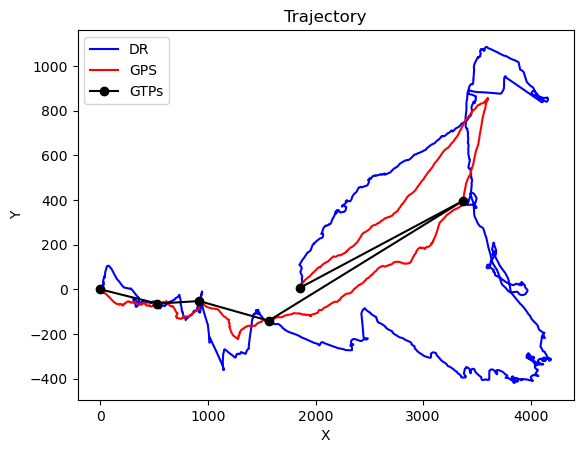

In [28]:
# Get data for plotting
dr_x = dr_trajectory['DR_x']
dr_y = dr_trajectory['DR_y']
utm_x = dr_trajectory['UTM_E'] - dr_trajectory.loc[0,'UTM_E']
utm_y = dr_trajectory['UTM_N'] - dr_trajectory.loc[0,'UTM_N']
gtps_x = gtps['UTM_E'] - dr_trajectory.loc[0,'UTM_E']
gtps_y = gtps['UTM_N'] - dr_trajectory.loc[0,'UTM_N']

# Initialize plot 
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dr_x,dr_y,  linestyle='-', color='b', label='DR')
ax.plot(utm_x,utm_y,  linestyle='-', color='r', label='GPS')
ax.plot(gtps_x,gtps_y, marker='o',  color='black', label='GTPs')

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()

In [ ]:


# # Filter DF to perform dead reckoning between first and last GTP
# # Get ground truth points
# gtp_start = gtps.iloc[0]
# gtp_end = gtps.iloc[-1]

# # Get timestamps of GTPs
# gtp_start_ts = gtp_start['datetime']
# gtp_end_ts = gtp_end['datetime']

# # Filter for DR pts that fall between gtp1 and gtp2
# df = df[(df['datetime'] >= gtp_start_ts) & (df['datetime'] <= gtp_end_ts)]
# df = df.reset_index()

In [ ]:
# # Initialize the transformation matrix
# transformation_matrix = np.eye(4)
# transformation_matrix

In [ ]:
# # Initialize position
# position = np.array([[0],[0],[0]])
# utm_x = df.loc[0,'UTM_E']
# utm_y = df.loc[0,'UTM_N']

# # Initialize columns for dead-reckoned coordinates
# df['DR_x'] = -999.0
# df.loc[0,'DR_x'] = 0
# df['DR_y'] = -999.0
# df.loc[0,'DR_y'] = 0
# df['DR_z'] = -999.0
# df.loc[0,'DR_z'] = -999.0
# df['DR_utm_x'] = -999.0
# df.loc[0,'DR_utm_x'] = df.loc[0,'UTM_E']
# df['DR_utm_y'] = -999.0
# df['DR_utm_y'] = df.loc[0,'UTM_N']

# # Initialize direciton
# initial_direction = np.array([[0],[1],[0]])

In [ ]:
# # Perform dead reckoning

# for i in range(len(df)-1 ):
    
#     global transformation_matrix
#     global position
#     global direction_vector
        
#     # Construct the rotation matrix
#     pitch = df.loc[i,'pitch']
#     roll = df.loc[i,'roll']
#     yaw = df.loc[i,'yaw']
#     Rx = get_rx(pitch)
#     Ry = get_ry(roll)
#     Rz = get_rz(yaw)
#     rotation_matrix = Rz @ Ry @ Rx

#     # Compute the displacement vector
#     direction_vector = rotation_matrix @ initial_direction
#     distance = df.loc[i,'d']
#     displacement_vector = direction_vector * distance
        
#     #update homo_trans_step
#     transformation_step = np.append(np.append(rotation_matrix, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
#     transformation_step[:3,-1] = displacement_vector.flatten()

#     # Perform initial calculation of coordinates
#     current_position = position
#     next_position = current_position + displacement_vector
#     df.loc[i+1,'DR_x'] = next_position[0]
#     df.loc[i+1,'DR_utm_x'] = displacement_vector[0] + df.loc[i,'DR_utm_x']
#     df.loc[i+1,'DR_y'] = next_position[1]
#     df.loc[i+1,'DR_utm_y'] = displacement_vector[1] + df.loc[i,'DR_utm_y']
#     df.loc[i+1,'DR_z'] = next_position[2]

#     # Update position
#     position = next_position


## APPLY CORRECTIONS

In [ ]:
# # Apply correction to each group
# df_step = df.copy()
# df_step['rowID'] = range(0,len(df_step))

# # Initialize empty data frame
# df_corrected = pd.DataFrame(columns=df.columns)

# # Get initial utm coords
# utm_x0 = df.loc[0,"UTM_E"]
# utm_y0 = df.loc[0,"UTM_N"]

# # Create a plot
# fig, ax = plt.subplots()

# # Apply corrections between each set of ground truth points
# for i in range(0,len(gtps)-1):
    
#     # Get ground truth points
#     gtp0 = gtps.iloc[i]
#     gtp1 = gtps.iloc[i+1]

#     # Get timestamps of GTPs
#     gtp0_ts = gtp0['datetime']
#     gtp1_ts = gtp1['datetime']

#     # Filter for DR pts that fall between gtp1 and gtp2
#     df_filt = df_step[(df_step['datetime'] >= gtp0_ts) & (df_step['datetime'] <= gtp1_ts)]
#     rowIDs = df_filt['rowID'].to_list()
#     s = rowIDs[0]
#     e = rowIDs[-1] 

#     # Get GPS coords (centered at 0,0)
#     gps_x0 = gtp0['UTM_E'] - utm_x0
#     gps_y0 = gtp0['UTM_N'] - utm_y0
#     gps_x1 = gtp1['UTM_E'] - utm_x0
#     gps_y1 = gtp1['UTM_N'] - utm_y0

#     # Get dead reckoned coords
#     dr_x0 = df_filt.loc[df_filt['rowID'] == s,'DR_x'].values
#     dr_y0 = df_filt.loc[df_filt['rowID'] == s,'DR_y'].values
#     dr_x1 = df_filt.loc[df_filt['rowID'] == e,'DR_x'].values
#     dr_y1 = df_filt.loc[df_filt['rowID'] == e,'DR_y'].values


#     # Define center of rotation
#     x_center = dr_x0
#     y_center = dr_y0
#     center_of_rotation = np.array([x_center,y_center,[0]])
    
#     # Subtract center of rotation from pts
#     gps_x0 = 0
#     gps_y0 = 0
#     gps_x1 = gps_x1 - x_center
#     gps_y1 = gps_y1 - y_center
#     dr_x0  = 0
#     dr_y0 = 0
#     dr_x1 = dr_x1 - x_center
#     dr_y1 = dr_y1 - y_center
#     print("gps0:"+str(gps_x0) + str(gps_y0))
#     print("dr0:"+str(dr_x0) + str(dr_y0))
#     print("gps1:"+str(gps_x1) + str(gps_y1))
#     print("dr1:"+str(dr_x1) + str(dr_y1))
    

    
#     # Calculate the distance correction factor
#     dist_GPS = math.sqrt((gps_x1-gps_x0)**2 + (gps_y1 - gps_y0)**2)
#     dist_dr = math.sqrt((dr_x1-dr_x0)**2 + (dr_y1 - dr_y0)**2)
#     dist_corr_fact = (dist_GPS/dist_dr)
    

#     # Calculate heading correction factor
#     bearing_GPS = math.atan2(gps_y1-gps_y0,gps_x1-gps_x0) 
#     bearing_dr = math.atan2(dr_y1-dr_y0,dr_x1-dr_x0) 
#     heading_corr_fact = (bearing_GPS-bearing_dr)
#     print(heading_corr_fact)
#     if heading_corr_fact < -math.pi:
#         heading_corr_fact += (360 * 0.0174533)
#     elif heading_corr_fact > math.pi:
#         heading_corr_fact -= (360 * 0.0174533)
#     heading_correction = R.from_euler('xyz', [0,0,heading_corr_fact]).as_matrix()
    

#     # Get points that will be corrected
#     Xs = df_step['DR_x'].to_numpy()
#     Ys = df_step['DR_y'].to_numpy()
#     Zs = np.zeros(len(df_step))
#     initial_coords = np.array([Xs,Ys,Zs]) - center_of_rotation
  
#     rotated_coords = ((heading_correction @ initial_coords)*np.array([[dist_corr_fact],[dist_corr_fact],[dist_corr_fact]]) ) + center_of_rotation
#     #translated_coords = rotated_coords * np.array([[dist_corr_fact],[dist_corr_fact],[dist_corr_fact]]) 
#     new_coords = rotated_coords
#     df_step['DR_x'] = new_coords[0]
#     df_step['DR_y'] = new_coords[1]
#     df_step['DR_z'] = new_coords[2]
#     df_step['DR_utm_x'] = df_step['DR_x'] + utm_x0
#     df_step['DR_utm_y'] = df_step['DR_y'] + utm_y0
#     # snap end point to gps
#     df_step.loc[e,'DR_utm_x'] == df_step.loc[e,'UTM_E']
#     df_step.loc[e,'DR_utm_y'] == df_step.loc[e,'UTM_N']
    
#     # Filter for rows between GTPs and append to df_corrected
#     df_step_filt = df_step[(df_step['rowID'] >= s) & (df_step['rowID'] <= e)]
#     df_corrected = pd.concat([df_corrected, df_step_filt], ignore_index=True)

#     # Add results to plot
#     dr_x = df_step_filt['DR_x']
#     dr_y = df_step_filt['DR_y']
#     utm_x = df_step_filt['UTM_E'] - utm_x0
#     utm_y = df_step_filt['UTM_N'] - utm_y0
#     gtps_x = gtps['UTM_E'] - utm_x0
#     gtps_y = gtps['UTM_N'] - utm_y0
#     if(i % 2 == 0):
#         clr = "b"
#     else:
#         clr = "g"
#     ax.plot(utm_x,utm_y, linestyle='-', color='r')
#     ax.plot(dr_x,dr_y,  linestyle='-', color=clr)
#     ax.plot(gtps_x,gtps_y,marker = "o",   color='black')


# # Add legend
# custom_lines = [Line2D([0], [0], color='r', lw=4),
#                 Line2D([0], [0], color='b', lw=4),
#                 Line2D([0], [0], color='g', lw=4),
#                Line2D([0], [0], color='black', lw=4)]

# ax.legend(custom_lines, ['GPS', 'DR', 'DR','GTP'])

# # Setting labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')

# # Adding a title and legend
# ax.set_title('Trajectory')


# # Show plot
# plt.show()
    